POP Planner for AI-Driven Precision Irrigation and Pest Mitigation

In [32]:
from __future__ import annotations
import pandas as pd
import json
from copy import deepcopy
from typing import List, Set, Tuple, Dict, Optional
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
df_plots = pd.read_csv("plots.csv")
plots = df_plots["plot"].tolist()
high_risk = set(df_plots[df_plots["high_risk"] == 1]["plot"])

with open("constraints.json", "r") as f:
    cfg = json.load(f)

duration = cfg["duration"]
water_per_irrigation = cfg["resources"]["water_per_irrigation"]
base_quota = cfg["resources"]["base_quota"]
vehicles = cfg["resources"]["vehicles"]
battery_capacity = cfg["resources"]["battery_capacity"]
days = cfg["resources"]["days"]

weekly_quota = int(base_quota * 0.7)
daily_quota = weekly_quota // days

Action representation

In [34]:
class Action:
    def __init__(self, name: str, a_type: str, plot: Optional[str], dur: int, water: int = 0, vehicle: Optional[str] = None,
                 pre: Optional[Set[str]] = None, add: Optional[Set[str]] = None, delete: Optional[Set[str]] = None):
        self.name = name
        self.type = a_type
        self.plot = plot
        self.dur = dur
        self.water = water
        self.vehicle = vehicle
        self.pre = set(pre) if pre else set()
        self.add = set(add) if add else set()
        self.delete = set(delete) if delete else set()

    def __repr__(self):
        v = f" [{self.vehicle}]" if self.vehicle else ""
        return f"{self.name}{v}"


Action factory (per-day)

In [35]:
def create_actions_for_day(day: int) -> Dict[str, Action]:
    acts: Dict[str, Action] = {}
    for p in plots:
        prefix = f"{p}_D{day}_"

        n = prefix + "CheckMoisture"
        acts[n] = Action(name=n, a_type="CheckMoisture", plot=p, dur=duration["CheckMoisture"], water=0,
                         pre={f"AtBase"}, add={f"Soil_{p}_D{day}_Checked"})

        n = prefix + "Irrigate"
        acts[n] = Action(name=n, a_type="Irrigate", plot=p, dur=duration["Irrigate"], water=water_per_irrigation,
                         pre={f"Soil_{p}_D{day}_Checked", "WaterAvailable"}, add={f"{p}_D{day}_Irrigated"}, delete={f"Soil_{p}_D{day}_Checked"})

        n = prefix + "CheckPest"
        acts[n] = Action(name=n, a_type="CheckPest", plot=p, dur=duration["CheckPest"], water=0,
                         pre={f"AtBase"}, add={f"Pest_{p}_D{day}_Checked"})

        n = prefix + "Spray"
        acts[n] = Action(name=n, a_type="Spray", plot=p, dur=duration["Spray"], water=0,
                         pre={f"Pest_{p}_D{day}_Checked"}, add={f"{p}_D{day}_Sprayed"})

    acts[f"ScheduleNextCycle_D{day}"] = Action(name=f"ScheduleNextCycle_D{day}", a_type="ScheduleNextCycle", plot=None,
                                                 dur=1, water=0, pre=set(), add={"NextCycleScheduled"})
    return acts

POP plan structure

In [36]:
 class POPPlan:
    def __init__(self):
        self.actions: List[Action] = []
        self.orderings: Set[Tuple[int,int]] = set()  # (i -> j)
        self.causal_links: Set[Tuple[int, str, int]] = set()  # (producer_idx, proposition, consumer_idx)

    def add_action(self, act: Action) -> int:
        self.actions.append(act)
        return len(self.actions) - 1

    def add_order(self, a: int, b: int):
        self.orderings.add((a,b))

    def add_causal(self, p_idx: int, prop: str, c_idx: int):
        self.causal_links.add((p_idx, prop, c_idx))

    def is_before(self, i: int, j: int) -> bool:
        if i == j:
            return False

        nodes = range(len(self.actions))
        reach = {n:set() for n in nodes}
        for (u,v) in self.orderings:
            reach[u].add(v)
        changed = True
        while changed:
            changed = False
            for u in nodes:
                for v in list(reach[u]):
                    for w in reach[v]:
                        if w not in reach[u]:
                            reach[u].add(w)
                            changed = True
        return j in reach[i]

    def pretty(self):
        print("\n=== POP Plan ===")
        for i,a in enumerate(self.actions):
            print(i, a)
        print("\nOrderings:")
        for o in sorted(self.orderings):
            print(f"  {o[0]} -> {o[1]}")
        print("\nCausal links:")
        for cl in self.causal_links:
            print(f"  {cl[0]} -[{cl[1]}]-> {cl[2]}")

Planner

In [37]:
def pop_planner_for_day(day: int, acts_lib: Dict[str, Action], available_water: int) -> Optional[POPPlan]:

    start = Action("Start", "Start", None, 0, pre=set(), add={"AtBase", "WaterAvailable"})
    finish_goals = set()
    for p in high_risk:
        finish_goals.add(f"{p}_D{day}_Irrigated")
        finish_goals.add(f"{p}_D{day}_Sprayed")
    finish_goals.add("NextCycleScheduled")
    finish = Action("Finish", "Finish", None, 0, pre=finish_goals, add=set())

    plan = POPPlan()
    s_idx = plan.add_action(start)
    f_idx = plan.add_action(finish)
    plan.add_order(s_idx, f_idx)

    open_goals: List[Tuple[int,str]] = [(f_idx, g) for g in finish_goals]

    total_water_used = 0
    vehicle_usage: Dict[str,int] = {v:0 for v in vehicles}


    iterations = 0
    while open_goals:
        iterations += 1
        if iterations > 5000:
            print("POP: too many iterations; aborting")
            return None
        consumer_idx, prop = open_goals.pop()


        if prop in plan.actions[s_idx].add:

            plan.add_causal(s_idx, prop, consumer_idx)
            plan.add_order(s_idx, consumer_idx)
            continue


        producing_indices = [i for i,a in enumerate(plan.actions) if prop in a.add]
        if producing_indices:
            producer_idx = producing_indices[0]

            plan.add_causal(producer_idx, prop, consumer_idx)
            plan.add_order(producer_idx, consumer_idx)

            for pre in plan.actions[producer_idx].pre:
                if pre not in plan.actions[s_idx].add:
                    open_goals.append((producer_idx, pre))

            resolve_threats(plan, producer_idx, consumer_idx, prop)
            continue


        selected = None
        selected_idx = None
        for a_name, a_template in acts_lib.items():
            if prop in a_template.add:

                candidates = [None]
                if a_template.type in ("Irrigate", "Spray"):

                    candidates = vehicles
                for veh in candidates:

                    a_copy = deepcopy(a_template)
                    a_copy.vehicle = veh

                    if a_copy.vehicle:
                        if a_copy.dur > battery_capacity:
                            continue

                    if a_copy.water + total_water_used > available_water:
                        continue

                    selected = a_copy
                    break
                if selected:
                    break
        if not selected:

            return None

        new_idx = plan.add_action(selected)
        plan.add_order(s_idx, new_idx)
        plan.add_order(new_idx, f_idx)
        total_water_used += selected.water

        plan.add_causal(new_idx, prop, consumer_idx)
        plan.add_order(new_idx, consumer_idx)

        for pre in selected.pre:
            if pre not in plan.actions[s_idx].add:
                open_goals.append((new_idx, pre))

        resolve_threats(plan, new_idx, consumer_idx, prop)

    return plan



def resolve_threats(plan: POPPlan, producer_idx: int, consumer_idx: int, prop: str) -> None:

    for t_idx, t_act in enumerate(plan.actions):
        if prop in t_act.delete:
            is_before_t_p = plan.is_before(t_idx, producer_idx)
            is_p_before_t = plan.is_before(producer_idx, t_idx)
            is_before_c_t = plan.is_before(consumer_idx, t_idx)
            is_t_before_c = plan.is_before(t_idx, consumer_idx)

            if (not is_before_t_p) and (not is_t_before_c):

                plan.add_order(t_idx, producer_idx)
                if plan.is_before(producer_idx, t_idx):

                    plan.orderings.remove((t_idx, producer_idx))
                    plan.add_order(consumer_idx, t_idx)
                    if plan.is_before(t_idx, consumer_idx):

                        raise RuntimeError(f"Threat for prop {prop} couldn't be resolved")

Visualizer

In [38]:
def visualize_pop(plan: POPPlan, title: str = "POP Plan"):
    G = nx.DiGraph()
    for i,a in enumerate(plan.actions):
        G.add_node(i, label=str(a))

    for (u,v) in plan.orderings:
        G.add_edge(u,v, style='solid', color='black')

    for (p,prop,c) in plan.causal_links:
        G.add_edge(p,c, style='dashed', color='red', label=prop)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,8))
    solid_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d.get('style')=='solid']
    dashed_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d.get('style')=='dashed']
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
    nx.draw_networkx_labels(G, pos, labels={n:G.nodes[n]['label'] for n in G.nodes()}, font_size=8)
    nx.draw_networkx_edges(G, pos, edgelist=solid_edges)
    nx.draw_networkx_edges(G, pos, edgelist=dashed_edges, style='dashed', edge_color='red')
    plt.title(title)
    plt.axis('off')
    plt.show()

Main driver

Running POP planner for 50 plots, days=7, vehicles=['Drone1', 'Drone2', 'AGV']

--- Day 1 ---
Day 1: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P7_D1_Irrigate [Drone1]
3 P7_D1_CheckMoisture
4 ScheduleNextCycle_D1
5 P22_D1_Irrigate [Drone1]
6 P22_D1_CheckMoisture
7 P30_D1_Irrigate [Drone1]
8 P30_D1_CheckMoisture
9 P30_D1_Spray [Drone1]
10 P30_D1_CheckPest
11 P22_D1_Spray [Drone1]
12 P22_D1_CheckPest
13 P3_D1_Spray [Drone1]
14 P3_D1_CheckPest
15 P3_D1_Irrigate [Drone1]
16 P3_D1_CheckMoisture
17 P7_D1_Spray [Drone1]
18 P7_D1_CheckPest
19 P15_D1_Spray [Drone1]
20 P15_D1_CheckPest
21 P15_D1_Irrigate [Drone1]
22 P15_D1_CheckMoisture

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  5 -> 1
  5 -> 5
  6 -> 1
  6 -> 5
  7 -> 1
  7 -> 7
  8 -> 1
  8 ->

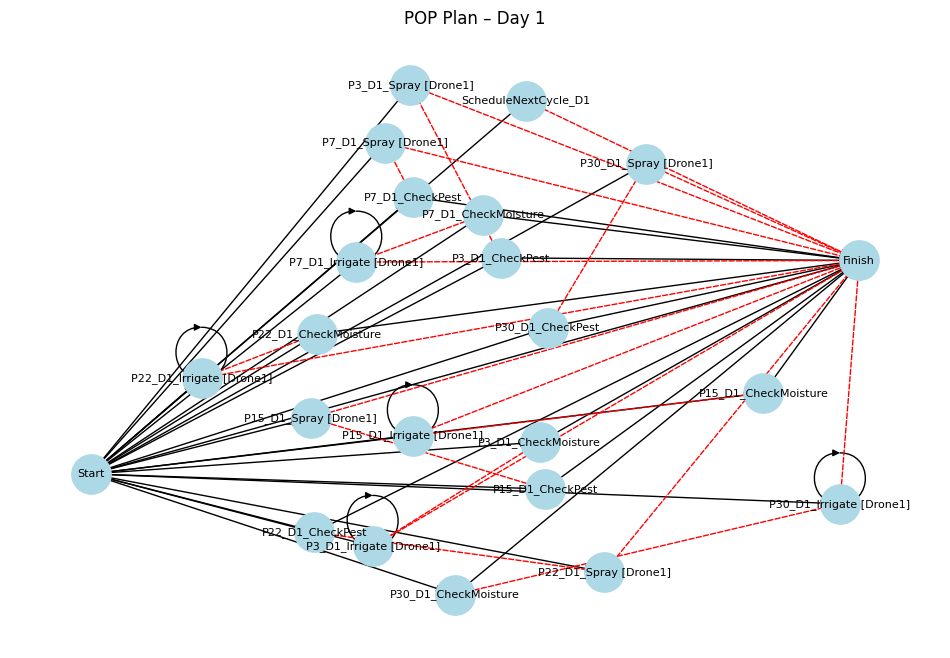


--- Day 2 ---
Day 2: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P22_D2_Spray [Drone1]
3 P22_D2_CheckPest
4 ScheduleNextCycle_D2
5 P7_D2_Spray [Drone1]
6 P7_D2_CheckPest
7 P15_D2_Irrigate [Drone1]
8 P15_D2_CheckMoisture
9 P22_D2_Irrigate [Drone1]
10 P22_D2_CheckMoisture
11 P15_D2_Spray [Drone1]
12 P15_D2_CheckPest
13 P3_D2_Spray [Drone1]
14 P3_D2_CheckPest
15 P30_D2_Spray [Drone1]
16 P30_D2_CheckPest
17 P7_D2_Irrigate [Drone1]
18 P7_D2_CheckMoisture
19 P3_D2_Irrigate [Drone1]
20 P3_D2_CheckMoisture
21 P30_D2_Irrigate [Drone1]
22 P30_D2_CheckMoisture

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  3 -> 1
  3 -> 2
  4 -> 1
  5 -> 1
  6 -> 1
  6 -> 5
  7 -> 1
  7 -> 7
  8 -> 1
  8 -> 7
  9 -> 1
  9 -> 9
  10 -> 1
  10 -> 9
  11 -> 1
  12 -> 1
  12 -> 11
  13 -> 1
  14 -> 1
  14 

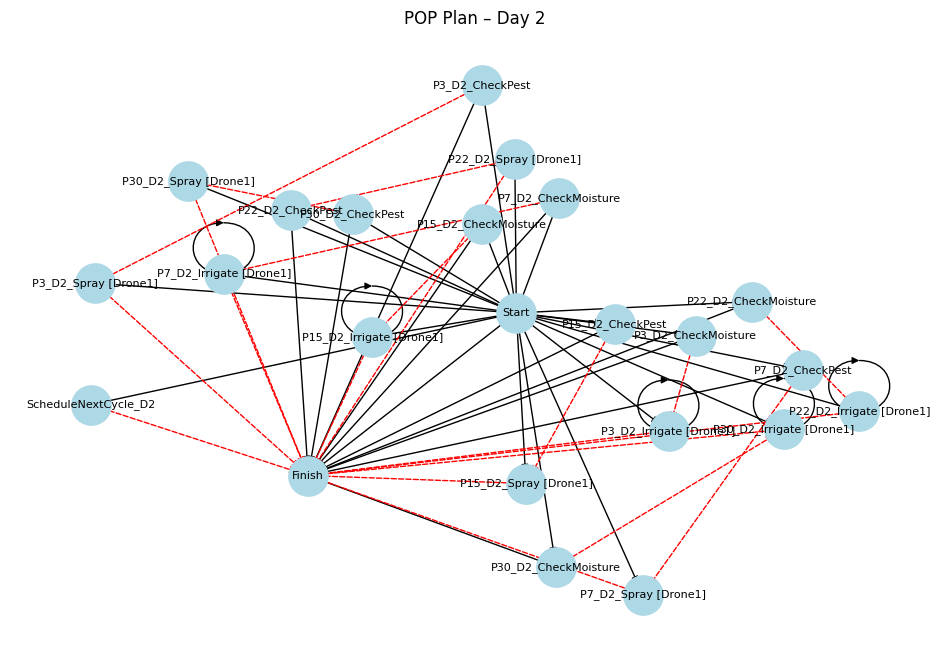


--- Day 3 ---
Day 3: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P22_D3_Irrigate [Drone1]
3 P22_D3_CheckMoisture
4 P30_D3_Irrigate [Drone1]
5 P30_D3_CheckMoisture
6 ScheduleNextCycle_D3
7 P30_D3_Spray [Drone1]
8 P30_D3_CheckPest
9 P15_D3_Irrigate [Drone1]
10 P15_D3_CheckMoisture
11 P15_D3_Spray [Drone1]
12 P15_D3_CheckPest
13 P3_D3_Irrigate [Drone1]
14 P3_D3_CheckMoisture
15 P7_D3_Spray [Drone1]
16 P7_D3_CheckPest
17 P7_D3_Irrigate [Drone1]
18 P7_D3_CheckMoisture
19 P3_D3_Spray [Drone1]
20 P3_D3_CheckPest
21 P22_D3_Spray [Drone1]
22 P22_D3_CheckPest

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  4 -> 4
  5 -> 1
  5 -> 4
  6 -> 1
  7 -> 1
  8 -> 1
  8 -> 7
  9 -> 1
  9 -> 9
  10 -> 1
  10 -> 9
  11 -> 1
  12 -> 1
  12 -> 11
  13 -> 1
  13 -

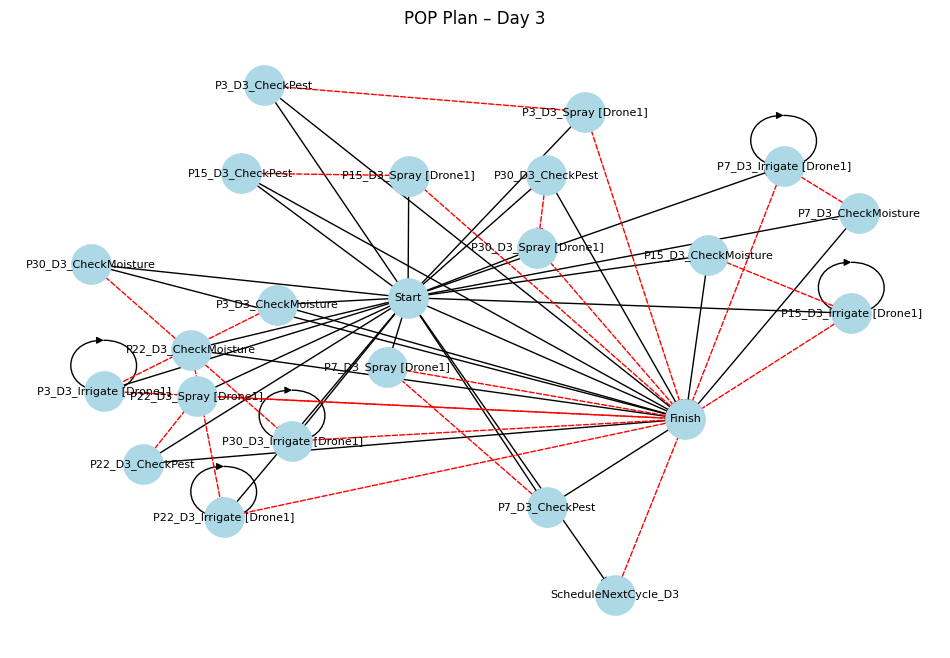


--- Day 4 ---
Day 4: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P30_D4_Irrigate [Drone1]
3 P30_D4_CheckMoisture
4 P7_D4_Irrigate [Drone1]
5 P7_D4_CheckMoisture
6 ScheduleNextCycle_D4
7 P22_D4_Spray [Drone1]
8 P22_D4_CheckPest
9 P3_D4_Irrigate [Drone1]
10 P3_D4_CheckMoisture
11 P30_D4_Spray [Drone1]
12 P30_D4_CheckPest
13 P15_D4_Irrigate [Drone1]
14 P15_D4_CheckMoisture
15 P22_D4_Irrigate [Drone1]
16 P22_D4_CheckMoisture
17 P15_D4_Spray [Drone1]
18 P15_D4_CheckPest
19 P3_D4_Spray [Drone1]
20 P3_D4_CheckPest
21 P7_D4_Spray [Drone1]
22 P7_D4_CheckPest

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  4 -> 4
  5 -> 1
  5 -> 4
  6 -> 1
  7 -> 1
  8 -> 1
  8 -> 7
  9 -> 1
  9 -> 9
  10 -> 1
  10 -> 9
  11 -> 1
  12 -> 1
  12 -> 11
  13 -> 1
  13 -

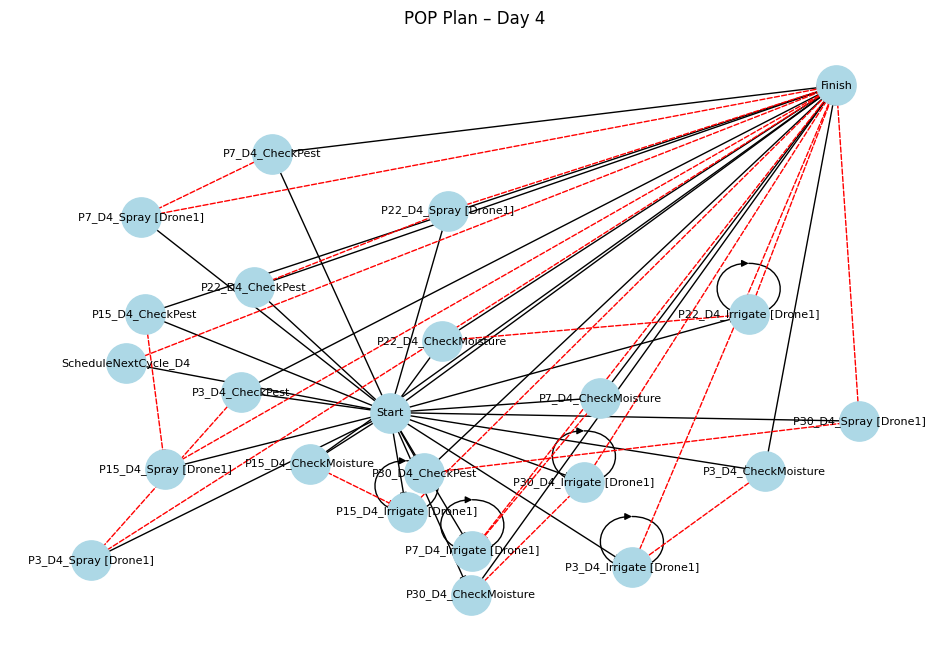


--- Day 5 ---
Day 5: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P22_D5_Irrigate [Drone1]
3 P22_D5_CheckMoisture
4 P15_D5_Irrigate [Drone1]
5 P15_D5_CheckMoisture
6 ScheduleNextCycle_D5
7 P3_D5_Irrigate [Drone1]
8 P3_D5_CheckMoisture
9 P7_D5_Irrigate [Drone1]
10 P7_D5_CheckMoisture
11 P30_D5_Spray [Drone1]
12 P30_D5_CheckPest
13 P22_D5_Spray [Drone1]
14 P22_D5_CheckPest
15 P15_D5_Spray [Drone1]
16 P15_D5_CheckPest
17 P7_D5_Spray [Drone1]
18 P7_D5_CheckPest
19 P30_D5_Irrigate [Drone1]
20 P30_D5_CheckMoisture
21 P3_D5_Spray [Drone1]
22 P3_D5_CheckPest

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  4 -> 4
  5 -> 1
  5 -> 4
  6 -> 1
  7 -> 1
  7 -> 7
  8 -> 1
  8 -> 7
  9 -> 1
  9 -> 9
  10 -> 1
  10 -> 9
  11 -> 1
  12 -> 1
  12 -> 11
  13 ->

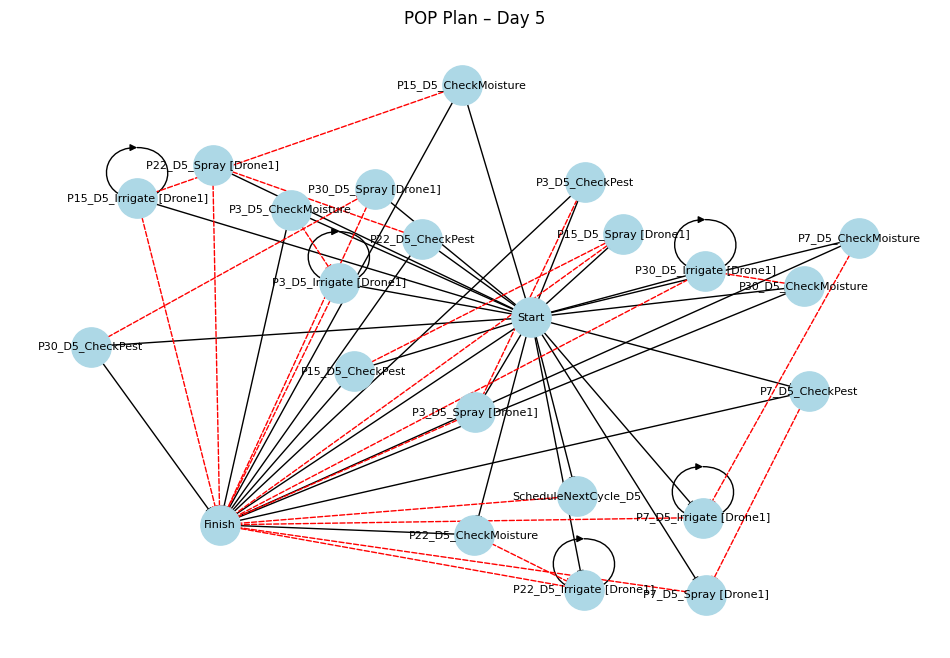


--- Day 6 ---
Day 6: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P30_D6_Irrigate [Drone1]
3 P30_D6_CheckMoisture
4 P7_D6_Irrigate [Drone1]
5 P7_D6_CheckMoisture
6 ScheduleNextCycle_D6
7 P3_D6_Irrigate [Drone1]
8 P3_D6_CheckMoisture
9 P3_D6_Spray [Drone1]
10 P3_D6_CheckPest
11 P15_D6_Spray [Drone1]
12 P15_D6_CheckPest
13 P15_D6_Irrigate [Drone1]
14 P15_D6_CheckMoisture
15 P22_D6_Spray [Drone1]
16 P22_D6_CheckPest
17 P30_D6_Spray [Drone1]
18 P30_D6_CheckPest
19 P22_D6_Irrigate [Drone1]
20 P22_D6_CheckMoisture
21 P7_D6_Spray [Drone1]
22 P7_D6_CheckPest

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  4 -> 4
  5 -> 1
  5 -> 4
  6 -> 1
  7 -> 1
  7 -> 7
  8 -> 1
  8 -> 7
  9 -> 1
  10 -> 1
  10 -> 9
  11 -> 1
  12 -> 1
  12 -> 11
  13 -> 1
  13 -

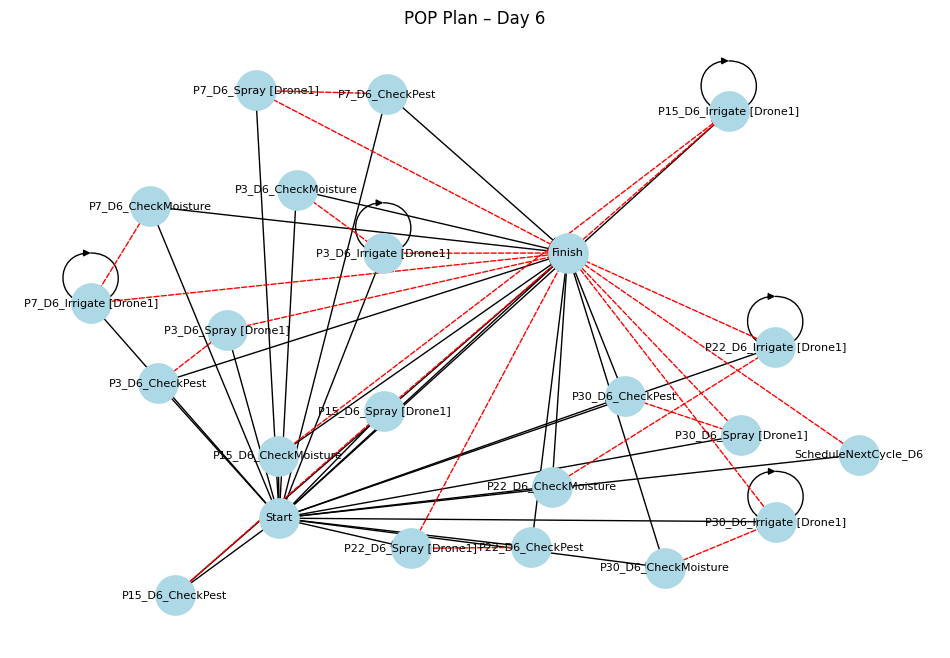


--- Day 7 ---
Day 7: POP produced plan using water=300

=== POP Plan ===
0 Start
1 Finish
2 P22_D7_Irrigate [Drone1]
3 P22_D7_CheckMoisture
4 ScheduleNextCycle_D7
5 P3_D7_Irrigate [Drone1]
6 P3_D7_CheckMoisture
7 P15_D7_Irrigate [Drone1]
8 P15_D7_CheckMoisture
9 P15_D7_Spray [Drone1]
10 P15_D7_CheckPest
11 P7_D7_Irrigate [Drone1]
12 P7_D7_CheckMoisture
13 P7_D7_Spray [Drone1]
14 P7_D7_CheckPest
15 P3_D7_Spray [Drone1]
16 P3_D7_CheckPest
17 P30_D7_Irrigate [Drone1]
18 P30_D7_CheckMoisture
19 P30_D7_Spray [Drone1]
20 P30_D7_CheckPest
21 P22_D7_Spray [Drone1]
22 P22_D7_CheckPest

Orderings:
  0 -> 1
  0 -> 2
  0 -> 3
  0 -> 4
  0 -> 5
  0 -> 6
  0 -> 7
  0 -> 8
  0 -> 9
  0 -> 10
  0 -> 11
  0 -> 12
  0 -> 13
  0 -> 14
  0 -> 15
  0 -> 16
  0 -> 17
  0 -> 18
  0 -> 19
  0 -> 20
  0 -> 21
  0 -> 22
  2 -> 1
  2 -> 2
  3 -> 1
  3 -> 2
  4 -> 1
  5 -> 1
  5 -> 5
  6 -> 1
  6 -> 5
  7 -> 1
  7 -> 7
  8 -> 1
  8 -> 7
  9 -> 1
  10 -> 1
  10 -> 9
  11 -> 1
  11 -> 11
  12 -> 1
  12 -> 11
  13 

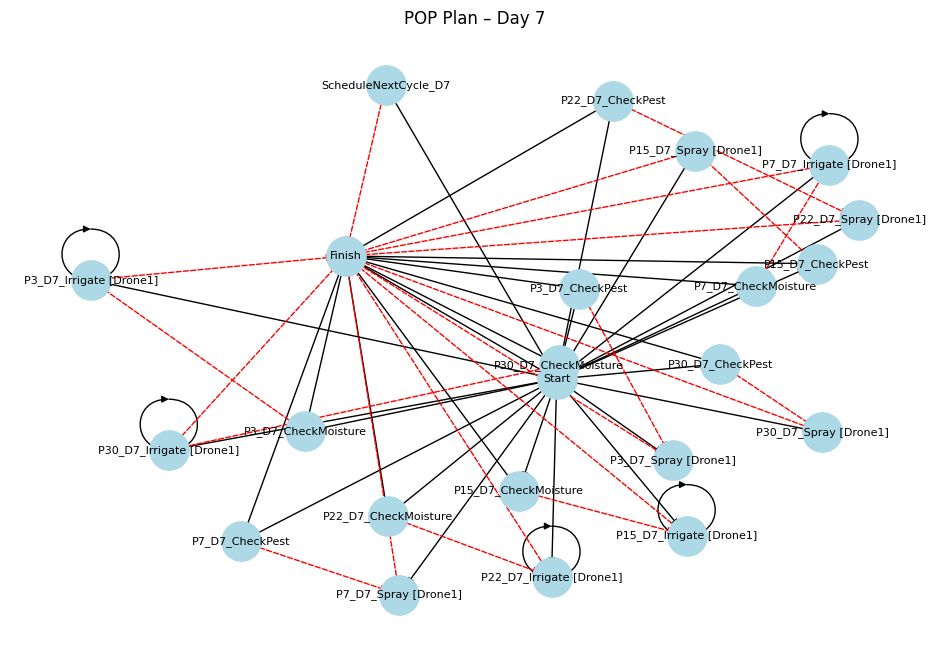


All done.


In [39]:
def main():
    print(f"Running POP planner for {len(plots)} plots, days={days}, vehicles={vehicles}")
    used_total = 0
    weekly_plans = {}
    for day in range(1, days+1):
        print(f"\n--- Day {day} ---")
        acts_lib = create_actions_for_day(day)
        available_water = min(daily_quota, max(0, weekly_quota - used_total))
        try:
            plan = pop_planner_for_day(day, acts_lib, available_water)
        except RuntimeError as e:
            print("Planner error:", e)
            plan = None
        if plan is None:
            print(f"Day {day}: No POP plan found under current constraints (available_water={available_water})")
            weekly_plans[day] = None
            continue

        used = sum(a.water for a in plan.actions)
        used_total += used
        print(f"Day {day}: POP produced plan using water={used}")
        plan.pretty()
        visualize_pop(plan, title=f"POP Plan – Day {day}")
        weekly_plans[day] = plan
    print("\nAll done.")

if __name__ == '__main__':
    main()